In [12]:
import warnings

import optuna

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import joblib
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import ClusterCentroids
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek


In [13]:
df = pd.read_csv('heart_2022_with_nans.csv')

# 1. Pochopenie dát
## Popis dát (Analýza datasetu)

In [14]:
# 1. Základná informácia
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [15]:
# 2. Informácie o číselných stĺpcoch
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434205.000000,436065.000000,439679.000000,416480.000000,403054.000000,396326.000000
mean,4.347919,4.382649,7.022983,1.702691,83.074470,28.529842
std,8.688912,8.387475,1.502425,0.107177,21.448173,6.554889
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


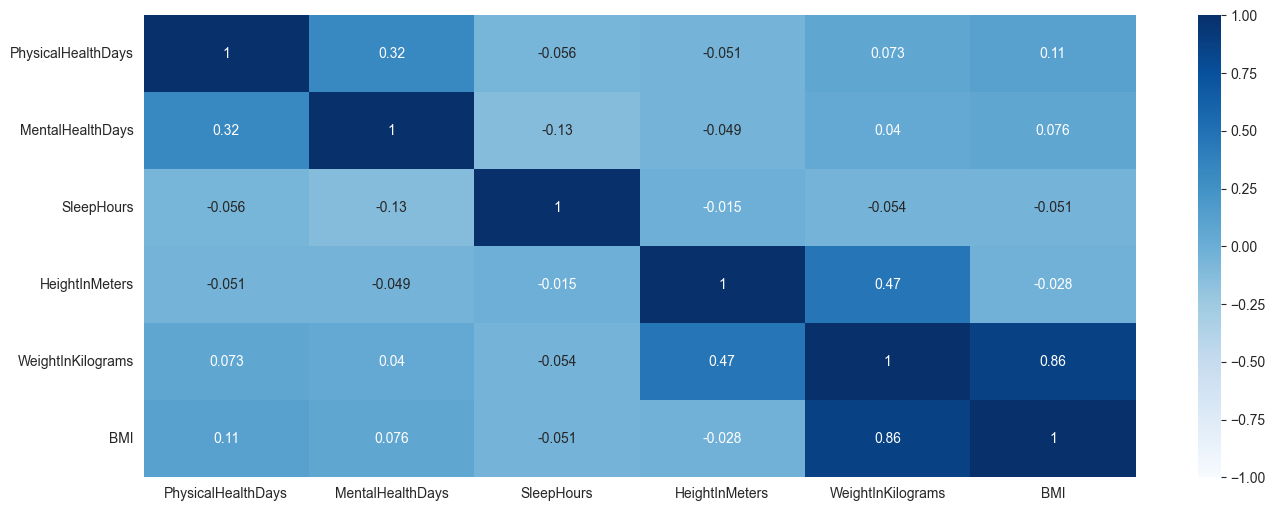

In [16]:
# 3. Korelačná matica všetkých číselných stĺpcoch
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.select_dtypes('float64').corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('', fontdict={'fontsize':18}, pad=12)
plt.savefig('img/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# 4. Pearsonove korelačné koeficienty medzi každým číselným stĺpcom a cieľovým stĺpcom HadHeartAttack
df_temp = df.copy()
df_temp = df_temp.dropna()
numerical_cols = df_temp.select_dtypes(include=['float64', 'int64']).columns

df_temp['HadHeartAttack'] = df_temp['HadHeartAttack'].map({'Yes': 1, 'No': 0})

pearson_correlation_results = {}
for col in numerical_cols:
    correlation, _ = stats.pearsonr(df_temp[col], df_temp['HadHeartAttack'])
    pearson_correlation_results[col] = correlation

print(pearson_correlation_results)

{'PhysicalHealthDays': 0.13341951288373385, 'MentalHealthDays': 0.02589196305211038, 'SleepHours': 0.0036309227894937833, 'HeightInMeters': 0.023058562103854565, 'WeightInKilograms': 0.03843558794571129, 'BMI': 0.03041348110554059}


                             chi_square        p_value
HIVTesting                    52.038529   5.442223e-13
HighRiskLastYear             109.355871   1.356153e-25
ECigaretteUsage              114.249955   1.335236e-24
HadDepressiveDisorder        137.997949   7.295212e-32
HadAsthma                    138.549511   5.526036e-32
RaceEthnicityCategory        195.916952   2.835486e-41
CovidPos                     210.971872   1.541843e-46
TetanusLast10Tdap            412.315795   4.757373e-89
State                        491.639417   2.258790e-72
FluVaxLast12                 503.020718  2.092796e-111
HadSkinCancer                599.800103  1.850453e-132
DifficultyConcentrating      655.921874  1.151408e-144
LastCheckupTime             1240.593273  1.142084e-268
BlindOrVisionDifficulty     1308.274108  1.799477e-286
Sex                         1321.783832  2.086026e-289
AlcoholDrinkers             1353.156122  3.175612e-296
DifficultyDressingBathing   1696.518134   0.000000e+00
PhysicalAc

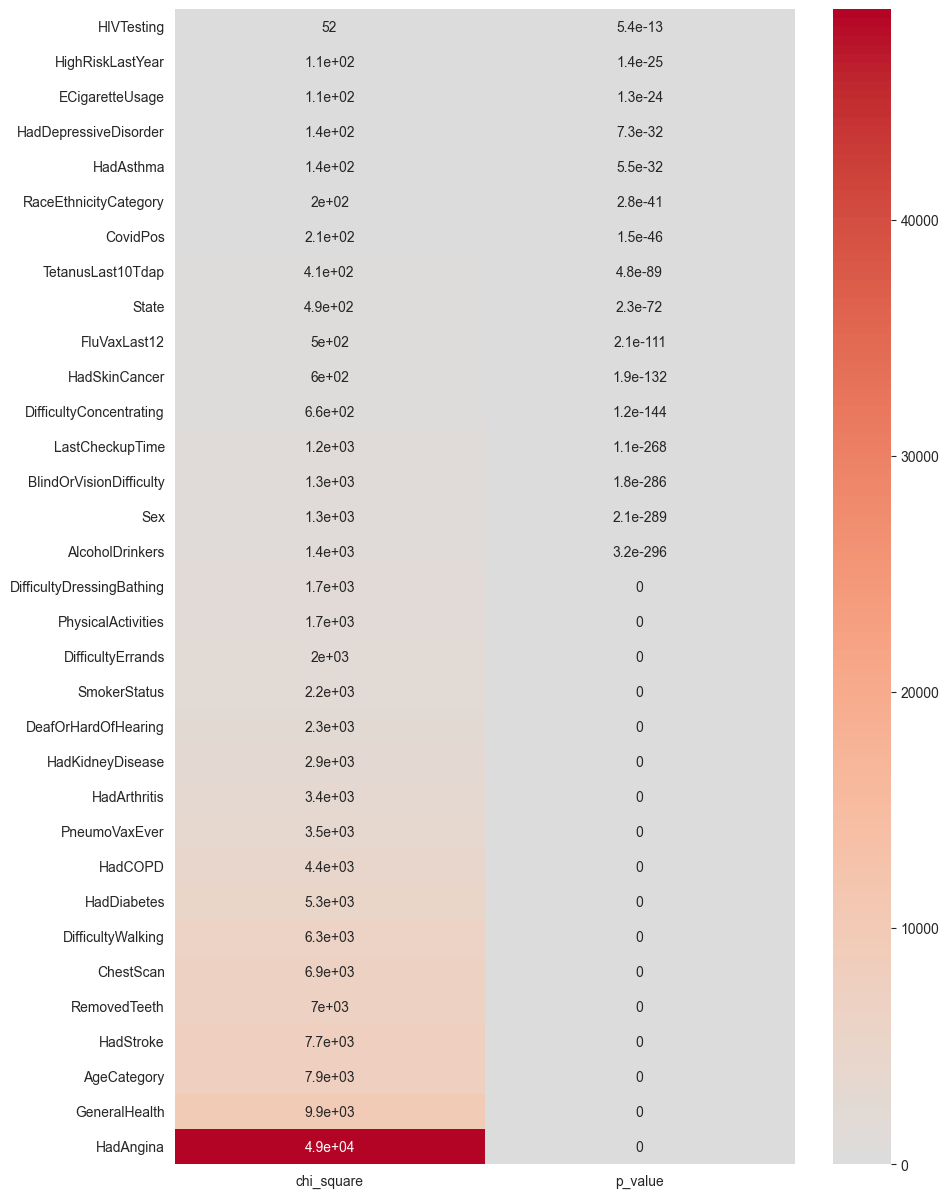

In [18]:
# 5. R — test chí-kvadrát. Korelácie medzi všetkými kategorickými premennými v datasete na základe cieľovej premennej 
df_temp = df.copy()
df_temp = df_temp.dropna()
df_temp['HadHeartAttack'] = df_temp['HadHeartAttack'].astype('category').cat.codes

categorical_columns = df_temp.select_dtypes(include=['object', 'category']).columns

chi_square_results = {}
for col in categorical_columns:
    contingency_table = pd.crosstab(df_temp['HadHeartAttack'], df_temp[col])
    chi_square_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = (chi_square_stat, p_value)

chi_square_results_df = pd.DataFrame(chi_square_results, index=['chi_square', 'p_value']).T

sorted_results_df = chi_square_results_df.sort_values(by='chi_square')
print(sorted_results_df)

plt.figure(figsize=(10, 15))
sns.heatmap(sorted_results_df, annot=True, cmap='coolwarm', center=0)
plt.savefig('img/chi_square1.png', dpi=150, bbox_inches='tight')
plt.show()

## Informácie o datasete

### Základné informácie
- Počet riadkov: 445132
- Počet stĺpcov: 40

### Dátové typy stĺpcov
 - Číselné stĺpce (**float64**): 6
    - PhysicalHealthDays
    - MentalHealthDays
    - SleepHours
    - HeightInMeters
    - WeightInKilograms
    - BMI
- Stĺpce s objektmi (**object**): 34
    - State
    - Sex
    - GeneralHealth
    - ... 
### 11 kategorických atribútov má veľmi nízku súvislosť s cieľovým atribútom;
### Atribúty WeightInKilograms a BMI majú vysokú koreláciu;
### Korelačný koeficient premennej SleepHours je veľmi blízky nule;
### 22 stĺpca s objektmi obsahujú hodnoty: [Yes, No].


## Verifikácia kvality dát
### Chýbajúce hodnoty (Analýza prázdnych hodnôt)

In [19]:
# 1. Počet všetkých prázdnych hodnôt v dataset
print("Prázdnych hodnôt v dataset: ",df.isnull().sum().sum())

Prázdnych hodnôt v dataset:  902665


In [20]:
# 2. Tabuľka počtu prázdnych hodnôt v každom stĺpci
df.isnull().sum()

State                            0
Sex                              0
GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
RaceEthnicityCategor

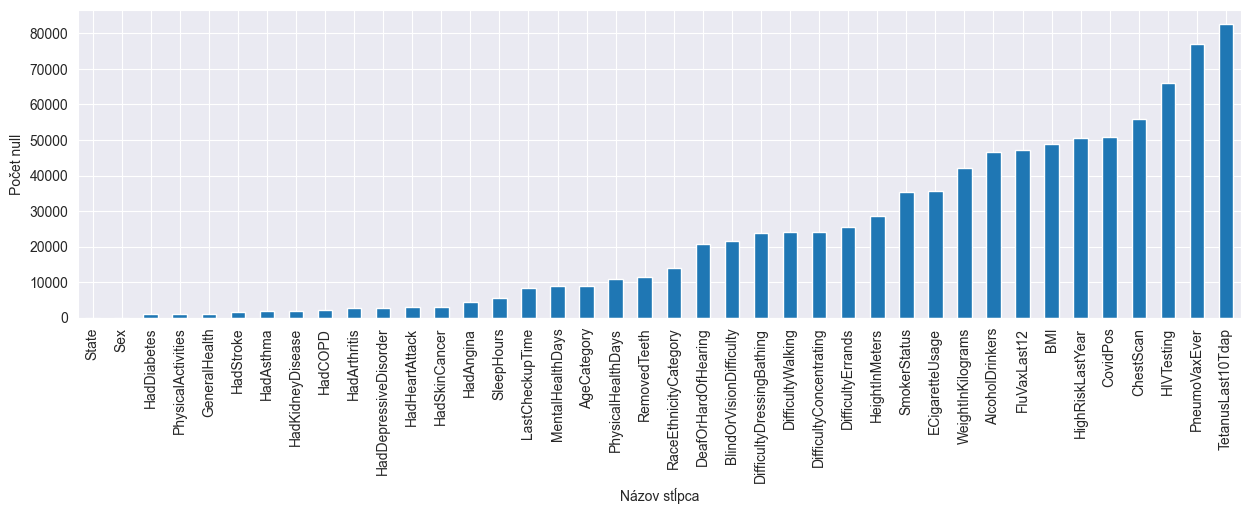

In [21]:
# 3. Graf počtu prázdnych hodnôt v každom stĺpci
df_null_summ = df.isnull().sum()
df_null_summ = df_null_summ.sort_values()
plt.figure(figsize=(15, 4)) 
ax = df_null_summ.plot(kind='bar')
ax.set_ylabel('Počet null')
ax.set_xlabel('Názov stĺpca')
plt.savefig('img/isnull.png', dpi=150, bbox_inches='tight')
plt.show()

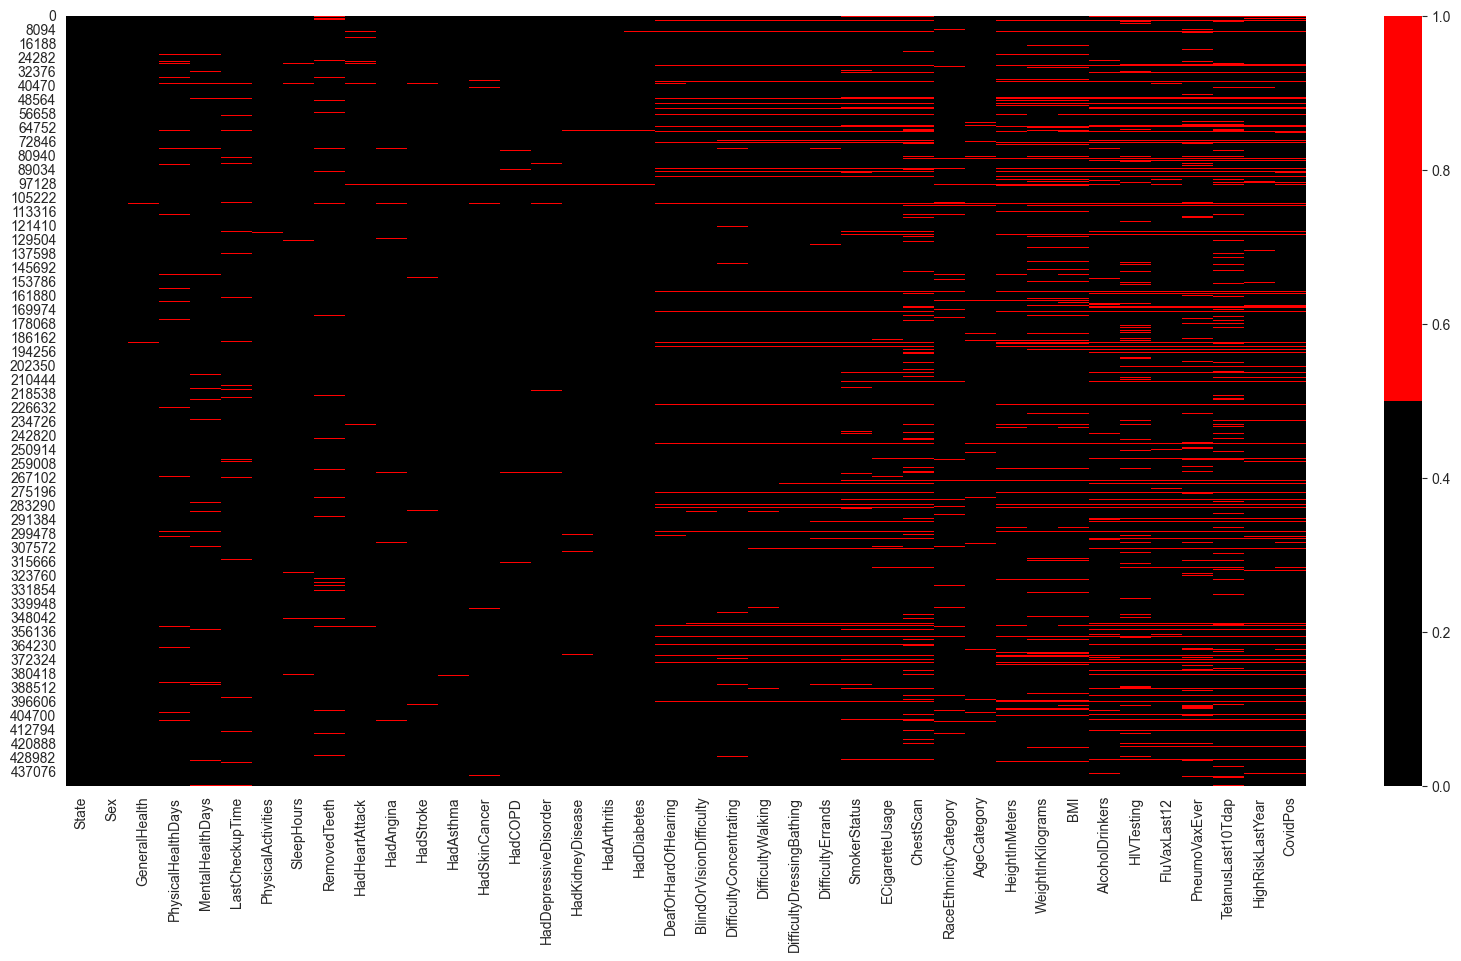

In [22]:
# 4. Tepelná mapa zobrazujúca, v ktorých častiach datasetu chýba najviac dát
plt.figure(figsize=(20, 10))
colors = ["black", "red"]
sns.heatmap(df.isnull(), cmap=sns.color_palette(colors), cbar={'label': 'Missing Data'})
plt.gcf().set_facecolor('white')
plt.savefig('img/missing_data_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### Počet riadkov, ktorý neobsahujú žiadne prázdny hodnoty: **246 022**

### Najväčší počet prázdnych hodnôt v stĺpcoch súvisiacich s lekárskymi procedúrami a testami
 - TetanusLast10Tdap: **82 516**
 - PneumoVaxEver: **77 040**
 - HIVTesting: **66 127**
### Veľký počet prázdnych hodnôt je v stĺpcoch opisujúcich fyzické obmedzenia osôb
 - DifficultyErrands: **25 656**
 - BlindOrVisionDifficulty: **21 564** 
 - DeafOrHardOfHearing: **20 647**
### Demografické stĺpce neobsahujú chýbajúce hodnoty
 - State (štát) a Sex (pohlavie)

### Výrazné odchýlky v číselných stĺpcoch

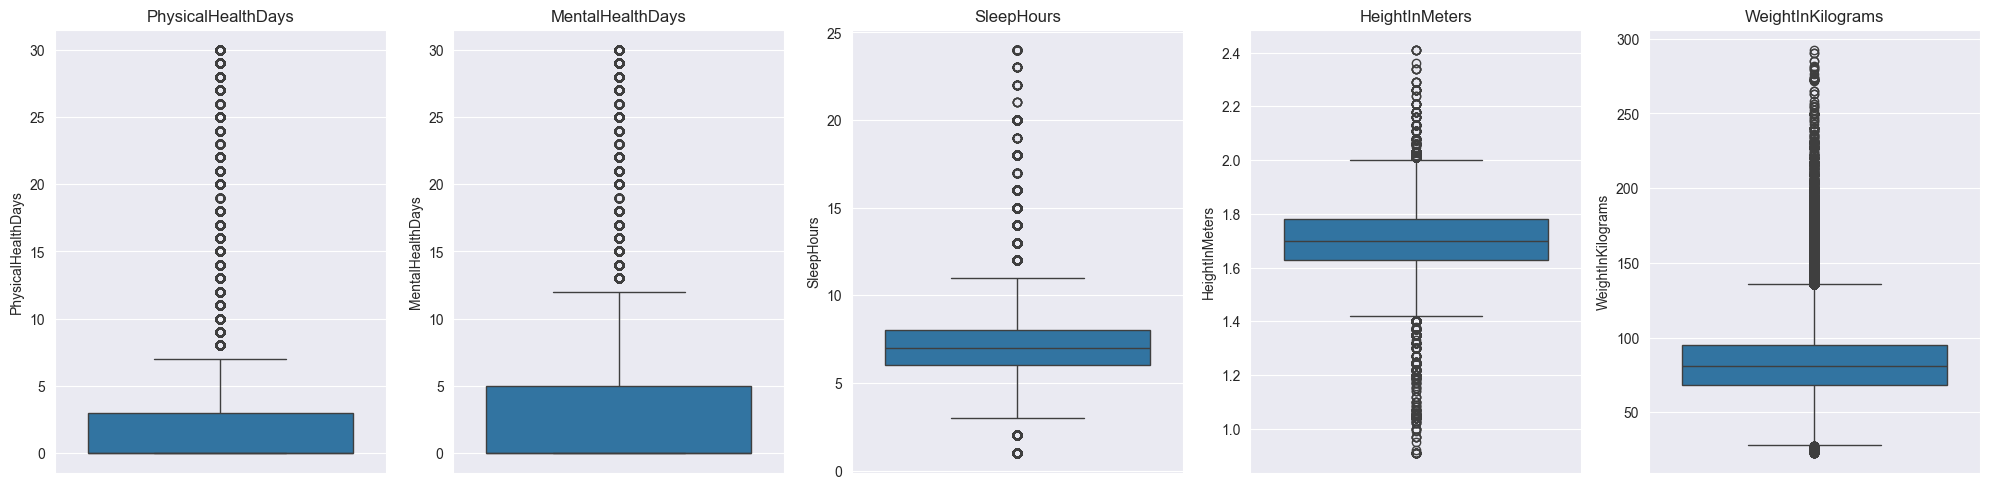

In [23]:
# 1. Analýza číselných stĺpcoch na obsah výrazných odchýlok
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(df['PhysicalHealthDays'], ax=axs[0])
axs[0].set_title('PhysicalHealthDays')

sns.boxplot(df['MentalHealthDays'], ax=axs[1])
axs[1].set_title('MentalHealthDays')

sns.boxplot(df['SleepHours'], ax=axs[2])
axs[2].set_title('SleepHours')

sns.boxplot(df['HeightInMeters'], ax=axs[3])
axs[3].set_title('HeightInMeters')

sns.boxplot(df['WeightInKilograms'], ax=axs[4])
axs[4].set_title('WeightInKilograms')

plt.tight_layout()
plt.savefig('img/extremeValues.png', dpi=150, bbox_inches='tight')
plt.show()

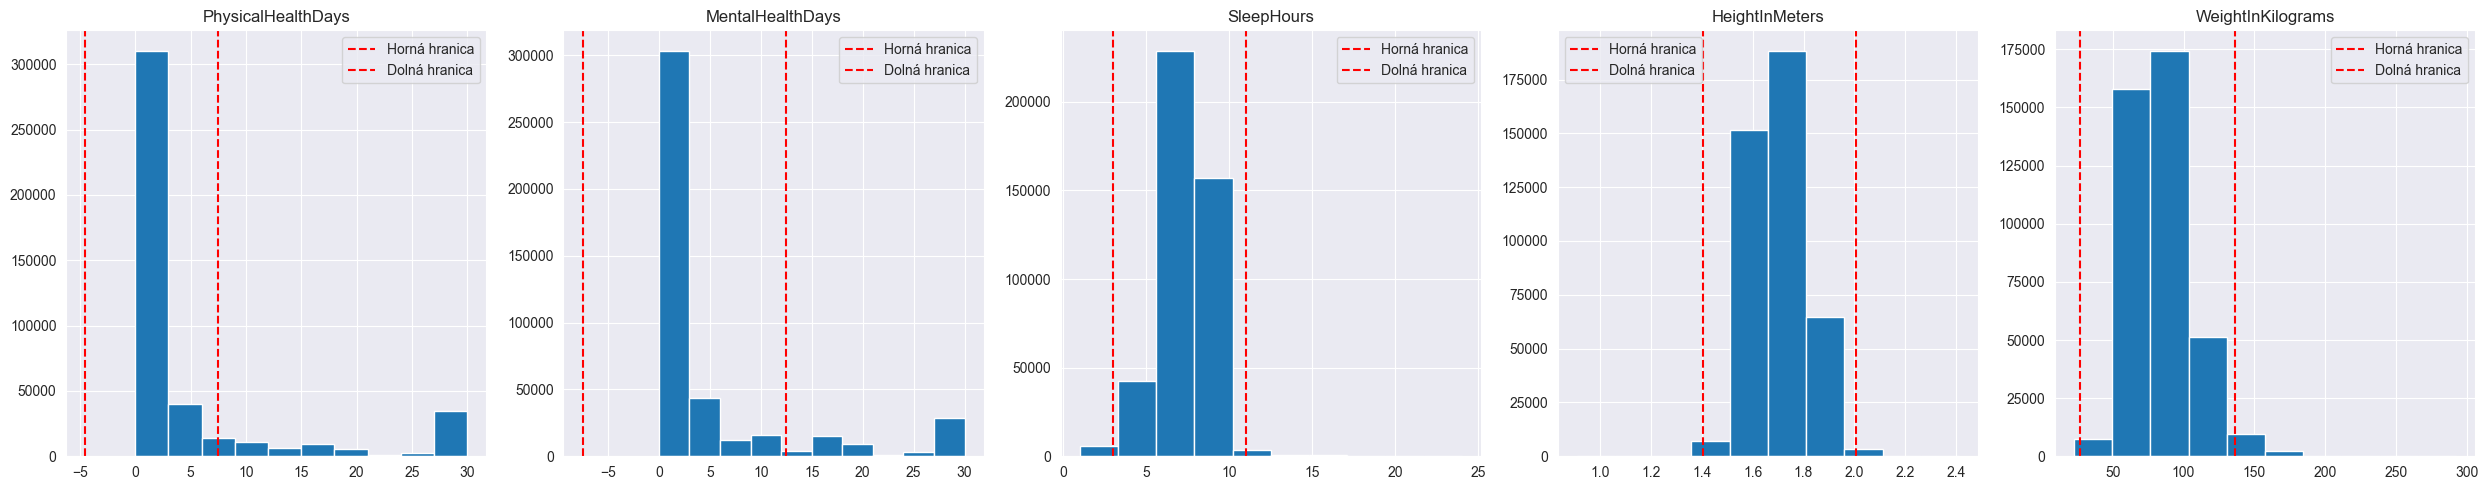

In [24]:
# 2. Analýza rozdelenie dat v číselných stĺpcoch
df_temp = df.copy()
df_temp.drop('BMI', axis=1, inplace=True)
numerical_columns = df_temp.select_dtypes(include=[np.number])
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
i =0
for column in numerical_columns:
  values = df_temp[column]

  q1 = values.quantile(0.25)
  q3 = values.quantile(0.75)
  iqr = q3 - q1

  upper_bound = q3 + 1.5 * iqr
  lower_bound = q1 - 1.5 * iqr

  outliers = values[(values > upper_bound) | (values < lower_bound)]

  axs[i].hist(values)
  axs[i].axvline(x=upper_bound, color='red', linestyle='--', label='Horná hranica')
  axs[i].axvline(x=lower_bound, color='red', linestyle='--', label='Dolná hranica')
  axs[i].legend()
  axs[i].set_title(f"{column}")
  i+=1
  
plt.tight_layout()
plt.savefig('img/outliers_in_line.png', dpi=150, bbox_inches='tight')
plt.show()

### Každý atribút obsahuje hodnoty, ktoré sa nachádzajú mimo odchýlky strednej hodnoty. 

### Nejednoznačnosť v kategóriách

In [25]:
# 1. Rozdelenie hodnôt niektorých kategorických premenných
print(df['HadAngina'].value_counts())
print()
print(df['RemovedTeeth'].value_counts())
print()
print(df['AgeCategory'].value_counts())
print()
print(df['HadDiabetes'].value_counts())

HadAngina
No     414176
Yes     26551
Name: count, dtype: int64

RemovedTeeth
None of them              233455
1 to 5                    129294
6 or more, but not all     45570
All                        25453
Name: count, dtype: int64

AgeCategory
Age 65 to 69       47099
Age 60 to 64       44511
Age 70 to 74       43472
Age 55 to 59       36821
Age 80 or older    36251
Age 50 to 54       33644
Age 75 to 79       32518
Age 40 to 44       29942
Age 45 to 49       28531
Age 35 to 39       28526
Age 18 to 24       26941
Age 30 to 34       25807
Age 25 to 29       21990
Name: count, dtype: int64

HadDiabetes
No                                         368722
Yes                                         61158
No, pre-diabetes or borderline diabetes     10329
Yes, but only during pregnancy (female)      3836
Name: count, dtype: int64


## Analýza cieľovej premennej

HadHeartAttack
No     416959
Yes     25108
Name: count, dtype: int64


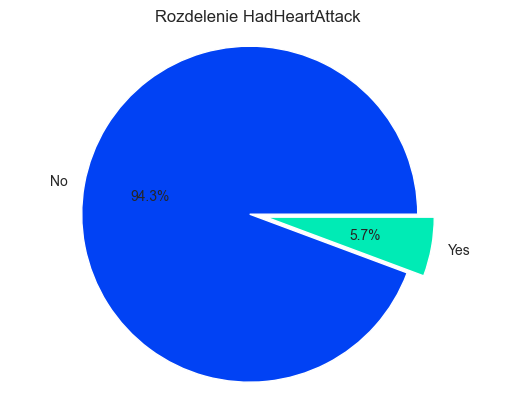

In [26]:
# 1. Rozdelenie hodnôt cieľovej premennej
print(df['HadHeartAttack'].value_counts())

heart_disease_column = df['HadHeartAttack'].value_counts()
plt.pie(heart_disease_column, labels = heart_disease_column.index, autopct="%1.1f%%", explode = [0,0.1], colors = ["#0142F4","#00EBB5"])
plt.title("Rozdelenie HadHeartAttack")
plt.axis("equal")
plt.savefig('img/RozdelenieHHA.png', dpi=150, bbox_inches='tight')
plt.show()

### Cieľová premenná má typ object obsahuje dve kategórie: [Yes, No] 
### Nerovnomernosť tried je vysoká - pomer je približne 1:16. Trieda 'Nie' je silne dominantná. 

# 2. Príprava dát 
## Rozdelenie datasetu

In [27]:
df = pd.read_csv('heart_2022_with_nans.csv')
#1. Odstránenie duplikátov a chýbajúcich hodnôt
df = df.drop_duplicates()
df_no_nan = df.dropna()

#2. Rozdelenie datasetu
X = df_no_nan.drop('HadHeartAttack', axis=1)
y = df_no_nan['HadHeartAttack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("X_test = ",X_test.shape)
print("X_train = ",X_train.shape)
print(y_test.value_counts())

#3. Uloženie dvoch samostatných množín údajov
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_test.to_csv('df_test.csv', index=False)
df_train.to_csv('df_train.csv', index=False)

X_test =  (49203, 39)
X_train =  (196810, 39)
HadHeartAttack
No     46516
Yes     2687
Name: count, dtype: int64


## Odstránenie stĺpcov "df_test"

In [28]:
df = pd.read_csv('df_test.csv')

In [29]:
# 1. Odstránenie stĺpcov na základe korelácie
df.drop('HadDepressiveDisorder', axis=1, inplace=True) 
df.drop('RaceEthnicityCategory', axis=1, inplace=True)
df.drop('FluVaxLast12', axis=1, inplace=True)
df.drop('CovidPos', axis=1, inplace=True)
df.drop('HadAsthma', axis=1, inplace=True)
df.drop('HadSkinCancer', axis=1, inplace=True)
df.drop('State', axis=1, inplace=True)
df.drop('TetanusLast10Tdap', axis=1, inplace=True)
# 2. Odstránenie stĺpcov na základe dôležitosti atribútov
df.drop('BMI', axis=1, inplace=True)

## Spracovanie kategorických stĺpcov "df_test"
### Transformácia do dvoch kategórii

In [30]:
# 1. Predspracovanie stĺpca 'HadDiabetes'
# Zobrazenie hodnôt v stĺpci 'HadDiabetes'
print(df['HadDiabetes'].value_counts()) 

# Je fakt o tom, či sa Diabete bol alebo nie.
mapping = {'No, pre-diabetes or borderline diabetes': 'No', 'Yes, but only during pregnancy (female)': 'Yes', 'No': 'No', 'Yes': 'Yes'}
df['HadDiabetes'] = df['HadDiabetes'].map(mapping)

HadDiabetes
No                                         41041
Yes                                         6705
No, pre-diabetes or borderline diabetes     1079
Yes, but only during pregnancy (female)      378
Name: count, dtype: int64


In [31]:
# 2. Predspracovanie stĺpca 'RemovedTeeth'
# Zobrazenie hodnôt v stĺpci 'RemovedTeeth'
print(df['RemovedTeeth'].value_counts()) 

# Vytvorenie stĺpca len s dvoma kategóriami ['Yes','No']
# Je fakt o tom, či boli zuby extrahované alebo nie.
mapping = {'1 to 5': 'Yes', '6 or more, but not all': 'Yes', 'All': 'Yes', 'None of them': 'No'}
df['RemovedTeeth'] = df['RemovedTeeth'].map(mapping)

RemovedTeeth
None of them              26430
1 to 5                    14814
6 or more, but not all     5196
All                        2763
Name: count, dtype: int64


In [32]:
# 3. Predspracovanie stĺpcov 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands'
# Zobrazenie hodnôt v stĺpci 'DifficultyWalking'
print(df['DifficultyWalking'].value_counts())

# Na základe dát z troch stĺpcov o schopnosti fyzickej aktivity - bol vytvorený nový stĺpec 'DifficultyMobility', pretože to všetko vedie k hypodynamike.
def get_new_col(row):
    if row['DifficultyWalking'] == 'Yes' or row['DifficultyDressingBathing'] == 'Yes' or row['DifficultyErrands'] == 'Yes':
        return 'Yes'
    elif pd.isna(row['DifficultyWalking']) and pd.isna(row['DifficultyDressingBathing']) and pd.isna(row['DifficultyErrands']): 
        return np.nan
    else:
        return 'No'
    
# Vytvorenie stĺpca len s dvoma kategóriami ['Yes','No']
df['DifficultyMobility'] = df.apply(get_new_col, axis=1)

# Vymazanie stĺpcov, ktoré už nie sú potrebné
df.drop('DifficultyWalking', axis=1, inplace=True)
df.drop('DifficultyDressingBathing', axis=1, inplace=True)
df.drop('DifficultyErrands', axis=1, inplace=True)

DifficultyWalking
No     41966
Yes     7237
Name: count, dtype: int64


###	Transformácia z kategórie na čísla

In [33]:
# 1. Prevod hodnôt ['Yes','No'] na 1 alebo 0
df.replace("Yes", 1, inplace=True)
df.replace("No", 0, inplace=True)

In [34]:
# 2. Predspracovanie stĺpca 'Sex'
# Zobrazenie hodnôt v stĺpci 'Sex'
print(df['Sex'].value_counts()) 

# Prevod hodnôt ['Male','Female'] na 0 alebo 1
df["Sex"].replace("Female", 1, inplace=True)
df["Sex"].replace("Male", 0, inplace=True)

Sex
Female    25613
Male      23590
Name: count, dtype: int64


GeneralHealth
Very good    17477
Good         15497
Excellent     8249
Fair          6035
Poor          1945
Name: count, dtype: int64


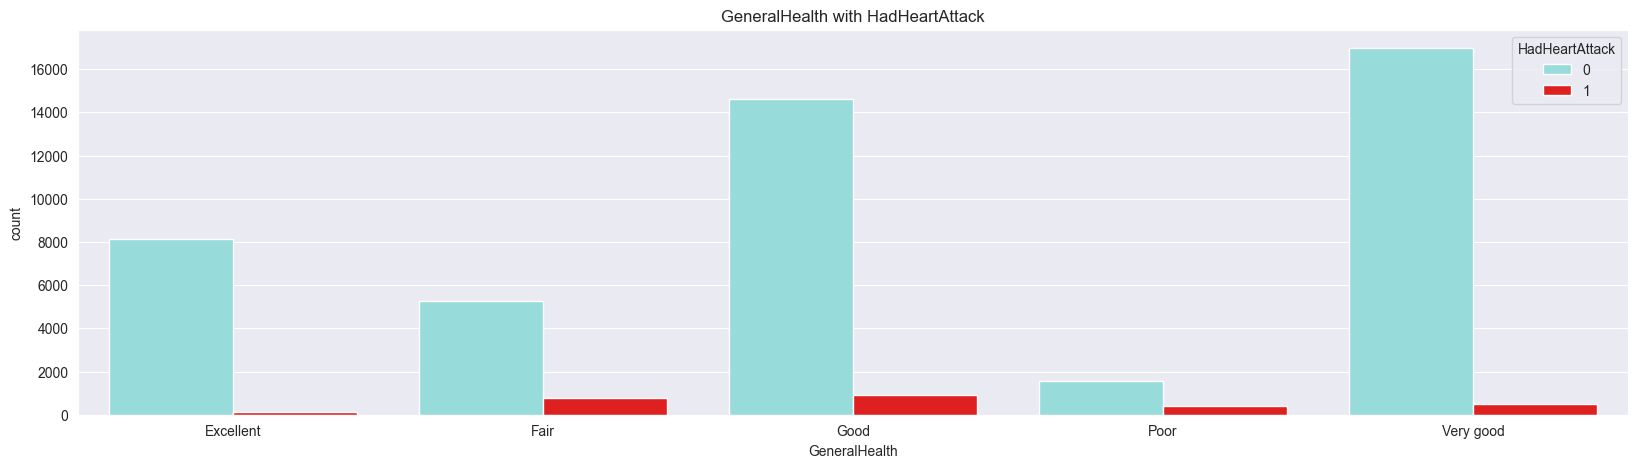

In [35]:
# 3. Predspracovanie stĺpca 'GeneralHealth'
# Zobrazenie hodnôt v stĺpci 'GeneralHealth'
print(df['GeneralHealth'].value_counts()) 

plt.figure(figsize = (20,5))
plt.title("GeneralHealth with HadHeartAttack")
sns.countplot(df.sort_values(by="GeneralHealth"),x="GeneralHealth",hue="HadHeartAttack",palette=["#8BE8E5","#FF0000"])

# Priradenie jedinečného celého čísla každej kategórii. 
mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}
df['GeneralHealth'] = df['GeneralHealth'].map(mapping)

AgeCategory
Age 65 to 69       5587
Age 60 to 64       5315
Age 70 to 74       5175
Age 55 to 59       4489
Age 50 to 54       4052
Age 75 to 79       3603
Age 80 or older    3585
Age 40 to 44       3407
Age 45 to 49       3301
Age 35 to 39       3158
Age 30 to 34       2672
Age 18 to 24       2619
Age 25 to 29       2240
Name: count, dtype: int64


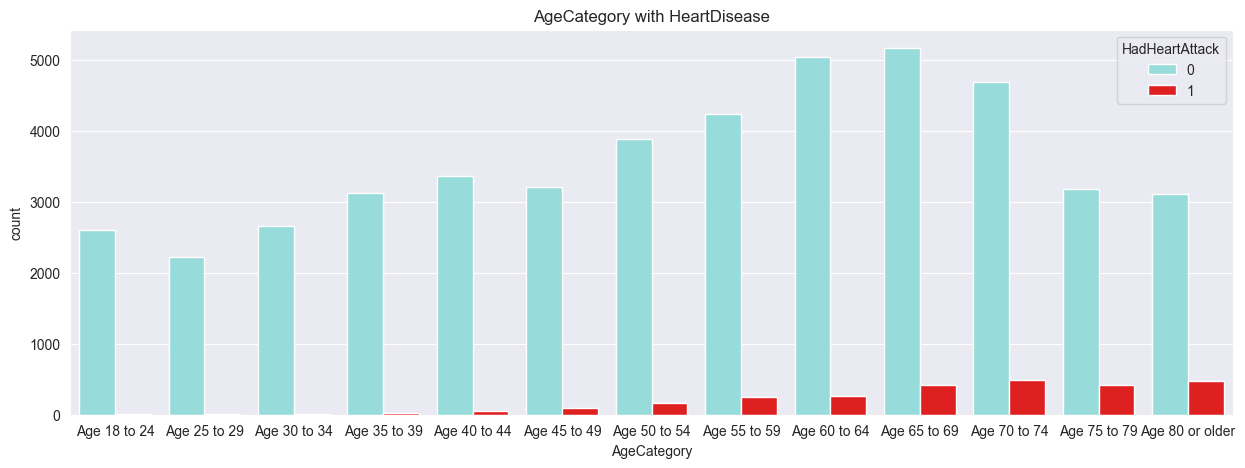

In [36]:
# 4. Predspracovanie stĺpca 'AgeCategory'
# Zobrazenie hodnôt v stĺpci 'AgeCategory'
print(df['AgeCategory'].value_counts()) 

plt.figure(figsize = (15,5))
plt.title("AgeCategory with HeartDisease")
sns.countplot(df.sort_values(by="AgeCategory"),x="AgeCategory",hue="HadHeartAttack",palette=["#8BE8E5","#FF0000"])

# Použite LabelEncoder na priradenie jedinečného celého čísla každej kategórii. 
le = LabelEncoder()
df['AgeCategory'] = le.fit_transform(df['AgeCategory'])

In [37]:
# 5. Predspracovanie stĺpca 'LastCheckupTime'
# Zobrazenie hodnôt v stĺpci 'LastCheckupTime'
print(df['LastCheckupTime'].value_counts()) 

# Použite LabelEncoder na priradenie jedinečného celého čísla každej kategórii. 
le = LabelEncoder()
df['LastCheckupTime'] = le.fit_transform(df['LastCheckupTime'])

LastCheckupTime
Within past year (anytime less than 12 months ago)         39615
Within past 2 years (1 year but less than 2 years ago)      4724
Within past 5 years (2 years but less than 5 years ago)     2717
5 or more years ago                                         2147
Name: count, dtype: int64


In [38]:
# 6. Predspracovanie stĺpcov 'SmokerStatus' a 'ECigaretteUsage' 
# Zobrazenie hodnôt v stĺpci 'SmokerStatus'
print(df['SmokerStatus'].value_counts())

# Nastavenie rovnakých, zodpovedajúcich hodnôt v stĺpcoch 'SmokerStatus_dict' a 'ECigaretteUsage_dict' 
SmokerStatus_dict = {'Never smoked': 1, 'Former smoker': 2, 'Current smoker - now smokes some days': 3, 'Current smoker - now smokes every day': 3}
ECigaretteUsage_dict = {'Never used e-cigarettes in my entire life': 1, 'Not at all (right now)': 2, 'Use them some days': 3, 'Use them every day': 3}

df['SmokerStatus'].replace(SmokerStatus_dict, inplace=True)
df['ECigaretteUsage'].replace(ECigaretteUsage_dict, inplace=True)

SmokerStatus
Never smoked                             29657
Former smoker                            13608
Current smoker - now smokes every day     4337
Current smoker - now smokes some days     1601
Name: count, dtype: int64


In [39]:
df.to_csv('df_testEDIT.csv', index=False)

## Odstránenie riadkov a stĺpcov "df_train"


In [40]:
df = pd.read_csv('df_train.csv')

In [41]:
# 1. Vymazanie riadku, ak je počet prázdnych hodnôt v ňom 7 alebo viac
df = df[~((df.isnull().sum(axis=1) > 7) & (df['HadHeartAttack'] == 'No'))]
# 2. Vymazanie duplikátov
df = df.drop_duplicates()
# 3. Odstránenie riadkov výrazných odchýlok (удалить выбросы)
mask = (df['HeightInMeters'] > 2.0) | (df['HeightInMeters'] < 1.5) | \
       (df['WeightInKilograms'] > 180) | (df['WeightInKilograms'] < 40) | \
       (df['SleepHours'] > 10) | (df['SleepHours'] < 4)

df = df[~mask]
# 4.1 Odstránenie riadkov na základe kritických atribútov 'HadAngina', 'HadStroke'
mask = (df['HadHeartAttack'] == 'No') & \
       (df['HadAngina'] == 'Yes') & \
       (df['HadStroke'] == 'Yes')

df = df[~mask]
# 4.2 Odstránenie riadkov na základe kritických atribútov 'HadAngina', 'HadStroke' a veku
mask = (df['HadHeartAttack'] == 'No') & \
       ((df['AgeCategory'] == 'Age 80 or older') | (df['AgeCategory'] == 'Age 75 to 79') | (df['AgeCategory'] == 'Age 70 to 74') | (df['AgeCategory'] == 'Age 65 to 69')) &\
       ((df['HadAngina'] == 'Yes') | (df['HadStroke'] == 'Yes'))

df = df[~mask]
# 5. Odstránenie stĺpcov na základe korelácie

df.drop('HadDepressiveDisorder', axis=1, inplace=True)
df.drop('RaceEthnicityCategory', axis=1, inplace=True)
df.drop('FluVaxLast12', axis=1, inplace=True)
df.drop('CovidPos', axis=1, inplace=True)
df.drop('HadAsthma', axis=1, inplace=True)
df.drop('HadSkinCancer', axis=1, inplace=True)
df.drop('State', axis=1, inplace=True)
df.drop('TetanusLast10Tdap', axis=1, inplace=True)
# 6. Odstránenie stĺpcov na základe dôležitosti atribútov
df.drop('BMI', axis=1, inplace=True)

## Spracovanie kategorických stĺpcov "df_train"
### Transformácia do dvoch kategórii

In [42]:
# 1. Predspracovanie stĺpca 'HadDiabetes'
# Zobrazenie hodnôt v stĺpci 'HadDiabetes'
print(df['HadDiabetes'].value_counts())

# Je fakt o tom, či sa Diabete bol alebo nie.
mapping = {'No, pre-diabetes or borderline diabetes': 'No', 'Yes, but only during pregnancy (female)': 'Yes',
           'No': 'No', 'Yes': 'Yes'}
df['HadDiabetes'] = df['HadDiabetes'].map(mapping)

HadDiabetes
No                                         153753
Yes                                         23374
No, pre-diabetes or borderline diabetes      3869
Yes, but only during pregnancy (female)      1509
Name: count, dtype: int64


In [43]:
# 2. Predspracovanie stĺpca 'RemovedTeeth'
# Zobrazenie hodnôt v stĺpci 'RemovedTeeth'
print(df['RemovedTeeth'].value_counts())

# Vytvorenie stĺpca len s dvoma kategóriami ['Yes','No']
# Je fakt o tom, či boli zuby extrahované alebo nie.
mapping = {'1 to 5': 'Yes', '6 or more, but not all': 'Yes', 'All': 'Yes', 'None of them': 'No'}
df['RemovedTeeth'] = df['RemovedTeeth'].map(mapping)

RemovedTeeth
None of them              100214
1 to 5                     55097
6 or more, but not all     17958
All                         9236
Name: count, dtype: int64


In [44]:
# 3. Predspracovanie stĺpcov 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands'
# Zobrazenie hodnôt v stĺpci 'DifficultyWalking'
print(df['DifficultyWalking'].value_counts())


# Na základe dát z troch stĺpcov o schopnosti fyzickej aktivity - bol vytvorený nový stĺpec 'DifficultyMobility', pretože to všetko vedie k hypodynamike.
def get_new_col(row):
    if row['DifficultyWalking'] == 'Yes' or row['DifficultyDressingBathing'] == 'Yes' or row[
        'DifficultyErrands'] == 'Yes':
        return 'Yes'
    elif pd.isna(row['DifficultyWalking']) and pd.isna(row['DifficultyDressingBathing']) and pd.isna(
            row['DifficultyErrands']):
        return np.nan
    else:
        return 'No'


# Vytvorenie stĺpca len s dvoma kategóriami ['Yes','No']
df['DifficultyMobility'] = df.apply(get_new_col, axis=1)

# Vymazanie stĺpcov, ktoré už nie sú potrebné
df.drop('DifficultyWalking', axis=1, inplace=True)
df.drop('DifficultyDressingBathing', axis=1, inplace=True)
df.drop('DifficultyErrands', axis=1, inplace=True)

DifficultyWalking
No     158803
Yes     23702
Name: count, dtype: int64


###	Transformácia z kategórie na čísla

In [45]:
# 1. Prevod hodnôt ['Yes','No'] na 1 alebo 0
df.replace("Yes", 1, inplace=True)
df.replace("No", 0, inplace=True)

In [46]:
# 2. Predspracovanie stĺpca 'Sex'
# Zobrazenie hodnôt v stĺpci 'Sex'
print(df['Sex'].value_counts())

# Prevod hodnôt ['Male','Female'] na 0 alebo 1
df["Sex"].replace("Female", 1, inplace=True)
df["Sex"].replace("Male", 0, inplace=True)

Sex
Female    94726
Male      87779
Name: count, dtype: int64


GeneralHealth
Very good    66309
Good         57070
Excellent    32133
Fair         21184
Poor          5809
Name: count, dtype: int64


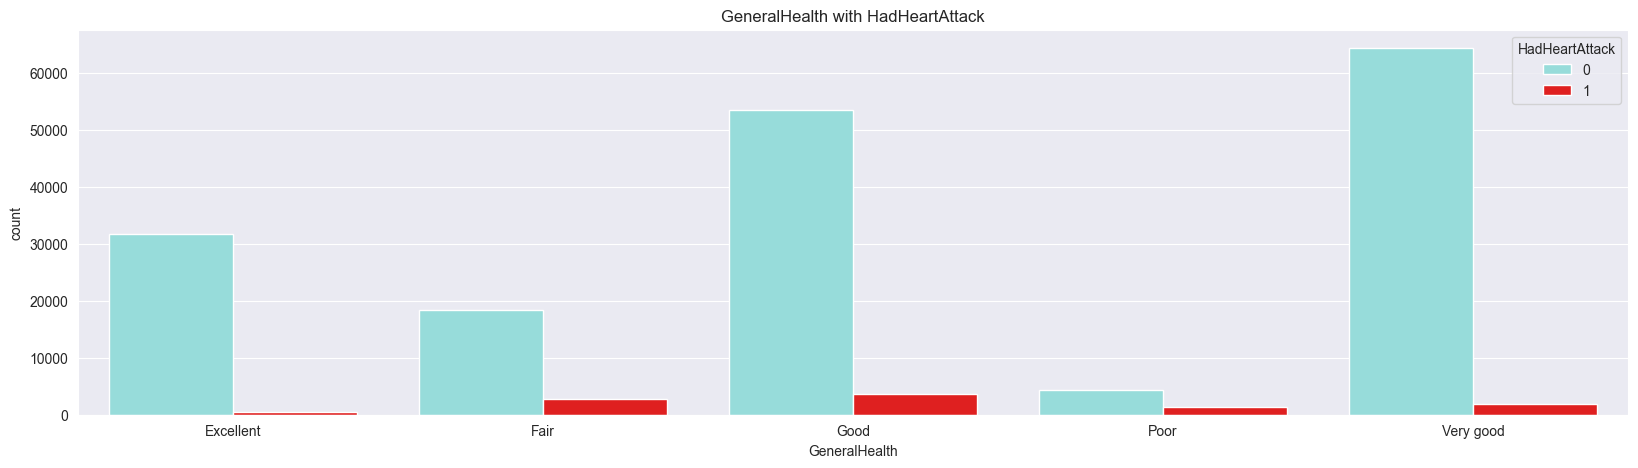

In [47]:
# 3. Predspracovanie stĺpca 'GeneralHealth'
# Zobrazenie hodnôt v stĺpci 'GeneralHealth'
print(df['GeneralHealth'].value_counts())

plt.figure(figsize=(20, 5))
plt.title("GeneralHealth with HadHeartAttack")
sns.countplot(df.sort_values(by="GeneralHealth"), x="GeneralHealth", hue="HadHeartAttack",
              palette=["#8BE8E5", "#FF0000"])

# Priradenie jedinečného celého čísla každej kategórii. 
mapping = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4}
df['GeneralHealth'] = df['GeneralHealth'].map(mapping)

AgeCategory
Age 60 to 64       20627
Age 65 to 69       20537
Age 70 to 74       17896
Age 55 to 59       17123
Age 50 to 54       15327
Age 40 to 44       13090
Age 45 to 49       13005
Age 75 to 79       12296
Age 35 to 39       12088
Age 80 or older    11417
Age 30 to 34       10310
Age 18 to 24       10199
Age 25 to 29        8590
Name: count, dtype: int64


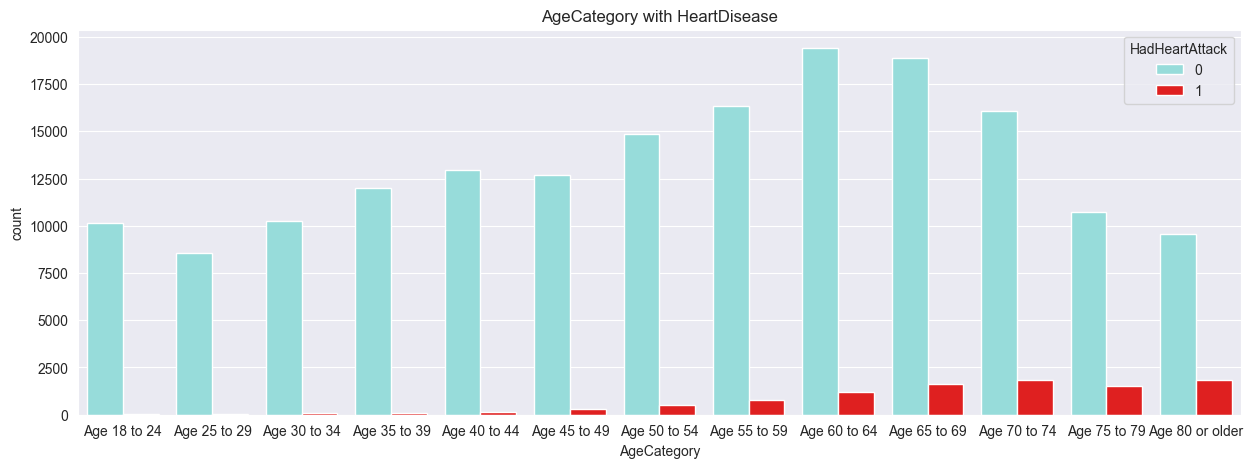

In [48]:
# 4. Predspracovanie stĺpca 'AgeCategory'
# Zobrazenie hodnôt v stĺpci 'AgeCategory'
print(df['AgeCategory'].value_counts())

plt.figure(figsize=(15, 5))
plt.title("AgeCategory with HeartDisease")
sns.countplot(df.sort_values(by="AgeCategory"), x="AgeCategory", hue="HadHeartAttack", palette=["#8BE8E5", "#FF0000"])

# Použite LabelEncoder na priradenie jedinečného celého čísla každej kategórii. 
le = LabelEncoder()
df['AgeCategory'] = le.fit_transform(df['AgeCategory'])

In [49]:
# 5. Predspracovanie stĺpca 'LastCheckupTime'
# Zobrazenie hodnôt v stĺpci 'LastCheckupTime'
print(df['LastCheckupTime'].value_counts())

# Použite LabelEncoder na priradenie jedinečného celého čísla každej kategórii. 
le = LabelEncoder()
df['LastCheckupTime'] = le.fit_transform(df['LastCheckupTime'])

LastCheckupTime
Within past year (anytime less than 12 months ago)         145830
Within past 2 years (1 year but less than 2 years ago)      17693
Within past 5 years (2 years but less than 5 years ago)     10598
5 or more years ago                                          8384
Name: count, dtype: int64


In [50]:
# 6. Predspracovanie stĺpcov 'SmokerStatus' a 'ECigaretteUsage' 
# Zobrazenie hodnôt v stĺpci 'SmokerStatus'
print(df['SmokerStatus'].value_counts())

# Nastavenie rovnakých, zodpovedajúcich hodnôt v stĺpcoch 'SmokerStatus_dict' a 'ECigaretteUsage_dict' 
SmokerStatus_dict = {'Never smoked': 1, 'Former smoker': 2, 'Current smoker - now smokes some days': 3,
                     'Current smoker - now smokes every day': 3}
ECigaretteUsage_dict = {'Never used e-cigarettes in my entire life': 1, 'Not at all (right now)': 2,
                        'Use them some days': 3, 'Use them every day': 3}

df['SmokerStatus'].replace(SmokerStatus_dict, inplace=True)
df['ECigaretteUsage'].replace(ECigaretteUsage_dict, inplace=True)

SmokerStatus
Never smoked                             110673
Former smoker                             49925
Current smoker - now smokes every day     15895
Current smoker - now smokes some days      6012
Name: count, dtype: int64


In [51]:
df.to_csv('df_trainEDIT.csv', index=False)

# 3. Modelovanie

## Resampling 

In [64]:
df_train = pd.read_csv('df_trainEDIT.csv')
df_test = pd.read_csv('df_testEDIT.csv')

# Rozdelenie df_train atribúty a cieľovú premennú
X_train = df_train.drop('HadHeartAttack', axis=1)
y_train = df_train['HadHeartAttack']

# Rozdelenie df_test atribúty a cieľovú premennú
X_test = df_test.drop('HadHeartAttack', axis=1)
y_test = df_test['HadHeartAttack']

### Výsledky trénovania modely RandomForestClassifier z TomekLinks

In [53]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))

Precision 0: 0.9706
Precision 1: 0.3942
Recall 0: 0.9558
Recall 1: 0.4980
F1 0: 0.9631
F1 1: 0.4401


### Výsledky trénovania modely RandomForestClassifier z TomekLinks a RandomUnderSampler

In [54]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))

Precision 0: 0.9852
Precision 1: 0.1875
Recall 0: 0.8018
Recall 1: 0.7920
F1 0: 0.8841
F1 1: 0.3032


### Výsledky trénovania modely RandomForestClassifier z TomekLinks a OneSidedSelection

In [181]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = OneSidedSelection(n_jobs=-1, random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))

Precision 0: 0.9705
Precision 1: 0.3942
Recall 0: 0.9559
Recall 1: 0.4965
F1 0: 0.9631
F1 1: 0.4395


### Výsledky trénovania modely RandomForestClassifier z TomekLinks a ClusterCentroids

In [183]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = ClusterCentroids(voting="soft", random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))

Precision 0: 0.9949
Precision 1: 0.0598
Recall 0: 0.1003
Recall 1: 0.9911
F1 0: 0.1823
F1 1: 0.1128


### Výsledky trénovania modely RandomForestClassifier z SMOTETomek

In [184]:
u_model = SMOTETomek(n_jobs=-1, random_state=42) 
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))

Precision 0: 0.9729
Precision 1: 0.3444
Recall 0: 0.9399
Recall 1: 0.5463
F1 0: 0.9561
F1 1: 0.4225


### Výsledky trénovania modely RandomForestClassifier z SMOTE

In [186]:
u_model = SMOTE(n_jobs=-1, random_state=42, sampling_strategy=1.0, k_neighbors=5)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))

Precision 0: 0.9723
Precision 1: 0.3438
Recall 0: 0.9410
Recall 1: 0.5352
F1 0: 0.9564
F1 1: 0.4186


## Trénovanie modelov 

### Random Forest Classifier štandardné hyperparametre a bez použitia resamplingu

In [65]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9703
Precision 1: 0.3933
Recall 0: 0.9561
Recall 1: 0.4927
F1 0: 0.9631
F1 1: 0.4375
[[44474  2042]
 [ 1363  1324]]


### Random Forest Classifier štandardné hyperparametre a resampling pomocou metód Tomek Links a RandomUnderSampler

In [66]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = RandomForestClassifier(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9852
Precision 1: 0.1875
Recall 0: 0.8018
Recall 1: 0.7920
F1 0: 0.8841
F1 1: 0.3032
[[37296  9220]
 [  559  2128]]


### Random Forest Classifier optimalizovane hyperparametre modelu a resampling pomocou metód Tomek Links a RandomUnderSampler

In [67]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = RandomForestClassifier(n_jobs=-1,  n_estimators = 534, max_features ='log2', max_depth = 22, random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9855
Precision 1: 0.1875
Recall 0: 0.8005
Recall 1: 0.7968
F1 0: 0.8835
F1 1: 0.3036
[[37238  9278]
 [  546  2141]]


### LogisticRegression štandardné hyperparametre a bez použitia resamplingu

In [68]:
model = LogisticRegression(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9712
Precision 1: 0.4512
Recall 0: 0.9645
Recall 1: 0.5047
F1 0: 0.9679
F1 1: 0.4765
[[44867  1649]
 [ 1331  1356]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### LogisticRegression štandardné hyperparametre a resampling pomocou metód Tomek Links a RandomUnderSampler

In [69]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = LogisticRegression(random_state=42, n_jobs=-1)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision 0: 0.9849
Precision 1: 0.2062
Recall 0: 0.8264
Recall 1: 0.7808
F1 0: 0.8987
F1 1: 0.3263
[[38440  8076]
 [  589  2098]]


### LogisticRegression optimalizovane hyperparametre modelu a resampling pomocou metód Tomek Links a RandomUnderSampler

In [70]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = LogisticRegression(random_state=42, n_jobs=-1, C=0.00057, max_iter=399, solver='sag')
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9858
Precision 1: 0.1516
Recall 0: 0.7359
Recall 1: 0.8169
F1 0: 0.8427
F1 1: 0.2557
[[34229 12287]
 [  492  2195]]


### SVC štandardné hyperparametre a bez použitia resamplingu

In [71]:
model = SVC(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9454
Precision 1: 0.0000
Recall 0: 1.0000
Recall 1: 0.0000
F1 0: 0.9719
F1 1: 0.0000
[[46516     0]
 [ 2687     0]]


### SVC štandardné hyperparametre a resampling pomocou metód Tomek Links a RandomUnderSampler

In [57]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = SVC(random_state=42)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

Precision 0: 0.9838
Precision 1: 0.2156
Recall 0: 0.8400
Recall 1: 0.7611
F1 0: 0.9063
F1 1: 0.3360
[[39074  7442]
 [  642  2045]]


### SVC optimalizovane hyperparametre modelu a resampling pomocou metód Tomek Links a RandomUnderSampler

In [56]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)
model = SVC(random_state=42, kernel = 'rbf', C = 184, max_iter=14444)
model.fit(X_trainRES, y_trainRES)
y_pred = model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

joblib.dump(model, 'model.pkl')

Precision 0: 0.9864
Precision 1: 0.1447
Recall 0: 0.7169
Recall 1: 0.8288
F1 0: 0.8303
F1 1: 0.2463
[[33348 13168]
 [  460  2227]]


['model.pkl']

## Vyhľadávanie optimálnych parametrov

### Random Forest Classifier

In [61]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)

def objective(trial):
    # Návrh hodnôt hyperparametrov
    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    max_depth = trial.suggest_int("max_depth", 20, 28)
    
    model = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators = n_estimators, max_features =max_features, max_depth = max_depth)
    model.fit(X_trainRES, y_trainRES)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)    
    return recall

# Vytvorenie objektu štúdie a optimalizácia cieľovej funkcie
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Vytvorenie modelu s najlepšími parametrami
best_params = trial.params
best_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
best_model.fit(X_trainRES, y_trainRES)

y_pred = best_model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

[I 2024-05-20 21:48:11,526] A new study created in memory with name: no-name-110a741f-5dd5-46fb-a3f0-0d587e698340
[I 2024-05-20 21:48:17,389] Trial 0 finished with value: 0.8001488649050986 and parameters: {'n_estimators': 716, 'max_features': 'log2', 'max_depth': 24}. Best is trial 0 with value: 0.8001488649050986.
[I 2024-05-20 21:48:18,379] Trial 1 finished with value: 0.79568291775214 and parameters: {'n_estimators': 129, 'max_features': 'sqrt', 'max_depth': 25}. Best is trial 0 with value: 0.8001488649050986.
[I 2024-05-20 21:48:21,001] Trial 2 finished with value: 0.7912169705991813 and parameters: {'n_estimators': 404, 'max_features': 'sqrt', 'max_depth': 22}. Best is trial 0 with value: 0.8001488649050986.
[I 2024-05-20 21:48:24,288] Trial 3 finished with value: 0.7945664309639002 and parameters: {'n_estimators': 576, 'max_features': 'log2', 'max_depth': 25}. Best is trial 0 with value: 0.8001488649050986.
[I 2024-05-20 21:48:26,133] Trial 4 finished with value: 0.7945664309639

Best trial:
  Value: 0.8001488649050986
  Params: 
    n_estimators: 716
    max_features: log2
    max_depth: 24
Precision 0: 0.9858
Precision 1: 0.1867
Recall 0: 0.7986
Recall 1: 0.8001
F1 0: 0.8824
F1 1: 0.3028
[[37150  9366]
 [  537  2150]]


### Logistic Regression

In [62]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)

def objective(trial):
    # Návrh hodnôt hyperparametrov
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver = trial.suggest_categorical('solver', ['liblinear', 'sag', 'saga', 'lbfgs', 'newton-cg'])

    model = LogisticRegression(n_jobs=-1, random_state=42, C=C, max_iter=max_iter, solver=solver)
    model.fit(X_trainRES, y_trainRES)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)    
    return recall

# Vytvorenie objektu štúdie a optimalizácia cieľovej funkcie
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Vytvorenie modelu s najlepšími parametrami
best_params = trial.params
best_model = LogisticRegression(**best_params, n_jobs=-1, random_state=42)
best_model.fit(X_trainRES, y_trainRES)

y_pred = best_model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

[I 2024-05-20 21:50:08,051] A new study created in memory with name: no-name-41445f53-ae0e-4ec8-bcb6-a2b826f4fbd2
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-05-20 21:50:10,067] Trial 0 finished with value: 0.7811685895050242 and parameters: {'C': 77.70897600410461, 'max_iter': 360, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7811685895050242.
[I 2024-05-20 21:50:13,158] Trial 1 finished with value: 0.7852623743952363 and parameters: {'C': 0.6013304149738684, 'max_iter': 538

Best trial:
  Value: 0.802381838481578
  Params: 
    C: 0.006881734808190221
    max_iter: 262
    solver: liblinear
Precision 0: 0.9860
Precision 1: 0.1907
Recall 0: 0.8033
Recall 1: 0.8024
F1 0: 0.8853
F1 1: 0.3081
[[37364  9152]
 [  531  2156]]


## SVC

In [63]:
u_model = TomekLinks(n_jobs=-1)
X_trainRES, y_trainRES = u_model.fit_resample(X_train, y_train)
u_model = RandomUnderSampler(random_state=42)
X_trainRES, y_trainRES = u_model.fit_resample(X_trainRES, y_trainRES)

def objective(trial):
    # Návrh hodnôt hyperparametrov
    C = trial.suggest_loguniform('C', 1, 1000)
    max_iter = trial.suggest_int('max_iter', 100, 50000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])

    model = SVC(random_state=42, C=C, max_iter=max_iter, kernel=kernel)
    model.fit(X_trainRES, y_trainRES)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)    
    return recall

# Vytvorenie objektu štúdie a optimalizácia cieľovej funkcie
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Vytvorenie modelu s najlepšími parametrami
best_params = trial.params
best_model = SVC(**best_params, random_state=42)
best_model.fit(X_trainRES, y_trainRES)

y_pred = best_model.predict(X_test)
print("Precision 0: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("Precision 1: {0:.4f}".format(precision_score(y_test, y_pred, pos_label=1)))
print("Recall 0: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("Recall 1: {0:.4f}".format(recall_score(y_test, y_pred, pos_label=1)))
print("F1 0: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("F1 1: {0:.4f}".format(f1_score(y_test, y_pred, pos_label=1)))
print(confusion_matrix(y_test, y_pred))

[I 2024-05-20 21:51:28,558] A new study created in memory with name: no-name-1a9d878c-393b-418c-8f17-6bf57ff72cea
[I 2024-05-20 21:51:31,684] Trial 0 finished with value: 0.6367696315593598 and parameters: {'C': 20.821848995204828, 'max_iter': 7976, 'kernel': 'linear'}. Best is trial 0 with value: 0.6367696315593598.
[I 2024-05-20 21:51:33,558] Trial 1 finished with value: 0.5586155563825828 and parameters: {'C': 88.15431435009953, 'max_iter': 3481, 'kernel': 'linear'}. Best is trial 0 with value: 0.6367696315593598.
[I 2024-05-20 21:51:45,087] Trial 2 finished with value: 0.5991812430219575 and parameters: {'C': 10.53926235363923, 'max_iter': 47408, 'kernel': 'linear'}. Best is trial 0 with value: 0.6367696315593598.
[I 2024-05-20 21:52:16,892] Trial 3 finished with value: 0.7830294008187569 and parameters: {'C': 14.830403294723698, 'max_iter': 26776, 'kernel': 'rbf'}. Best is trial 3 with value: 0.7830294008187569.
[I 2024-05-20 21:52:46,282] Trial 4 finished with value: 0.7688872348

Best trial:
  Value: 0.8235950874581317
  Params: 
    C: 1.4036011615739685
    max_iter: 49527
    kernel: rbf
Precision 0: 0.9864
Precision 1: 0.1529
Recall 0: 0.7365
Recall 1: 0.8236
F1 0: 0.8433
F1 1: 0.2580
[[34259 12257]
 [  474  2213]]


Best trial:
  Value: 0.8235950874581317
  Params:
    C: 1.4036011615739685
    max_iter: 49527
    kernel: rbf